# Assignment 3#

 Piyanka Vasanthakumari

**Question 1 (20pts)** Implement DQN (with experience replay) using a Neural Network as the Q function approximator on the LunarLander-v2 environment from OpenAI gym. Plot the total reward obtained **per episode**. The problem is solved if the total  reward per episode is **200 or above**. You may have to use a  sliding average window to get clean plots. Link your plot in the code block below. 

In [20]:
!apt-get update
!apt-get install xvfb
!apt-get install x11-utils
!apt-get install ffmpeg
!apt-get install python-opengl 
!pip -q install gym pyvirtualdisplay pygame
!pip3 install box2d-py


"""ENVIRONMENT"""
import gym                                                                      #OpenAI gym 
gym.logger.set_level(40)                                                        #suppresses warning messages, displays only error messages

"""MODELS AND TOOLS FOR OPTIMIZATION AND OTHER COMPUTATIONS"""
import time
import numpy as np
import torch                                                                    #will use PyTorch to handle the NN 
import torch.nn as nn                                                           #contains various NN layers
import torch.nn.functional as F                                                 #includes various functions such as convolution etc.
import torch.optim as optim                                                     #contains various optimization algorithms
import random
from random import sample
from collections import deque, namedtuple

"""VISUALIZATION"""
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import base64

"""I/O"""
import os
from pathlib import Path

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-le

In [21]:
display=Display(visible=0, size=(600, 400))
display.start()

#Define a simple helper function to visualize the episodes
def show_video(path):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [22]:
env = gym.make("LunarLander-v2")
env.seed(0)
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
env.reset()
done = False
while not done:
    action = 1
    obs, reward, done, info = env.step(action)
env.close()
show_video('./video')

In [23]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
env.seed(0)
print('State shape: ', env.observation_space.shape[0])
print('Number of actions: ', env.action_space)

State shape:  8
Number of actions:  Discrete(4)


In [24]:
from google.colab import drive
from google.colab import files

def save_checkpoint(model, filename, mode=0):
    """
    Save a model to a file in your colab space 
        
    Parameters
    ----------
    model: your policy network
    filename: the name of the checkpoint file
    mode (int): determines where to store the file
                --> 0: collab space 1: Google Drive
    """
    if mode == 1: 
      drive.mount('/content/gdrive')
      path = F"/content/gdrive/My Drive/{filename}" 
      torch.save(model.state_dict(), path)
    else:
      torch.save(model.state_dict(), filename)


In [25]:
##NEURAL NETWORK##

class Network(nn.Module):
  def __init__(self, state_num, action_num, seed, hiddenlayer1, hiddenlayer2):
    super(Network, self).__init__()
    self.seed = torch.manual_seed(seed)
    self.fc1 = nn.Linear(state_num, hiddenlayer1)
    self.fc2 = nn.Linear(hiddenlayer1, hiddenlayer2)
    self.fc3 = nn.Linear(hiddenlayer2, action_num)
  
  def forward(self, state):
    x=state
    if not isinstance(state, torch.Tensor):
      x = torch.tensor(state, device = device, dtype = torch.float32)
      x = x.unsqueeze(0)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return(x)

In [27]:
#PARAMETERS#
import numpy as np
seed = 0
hid_layer1 = 64
hid_layer2 = 64
minibatch_size = 64

buffer_size = int(1e5)
max_experiences = 350000
max_step = 1
gamma = 0.99
epochs = 1
Update_step = 100
LR = 5e-4 

class DQNagent():
  def __init__(self, env, seed, hid_layer1,hid_layer2):
    self.state_size = env.observation_space.shape[0]
    self.action_size = env.action_space.n
    self.hid_layer1 = hid_layer1
    self.hid_layer2 = hid_layer2
    #Policy and target networks
    self.policy_net = Network(self.state_size,self.action_size,seed,self.hid_layer1,self.hid_layer2).to(device)
    self.target_net = Network(self.state_size,self.action_size,seed,self.hid_layer1,self.hid_layer2).to(device)
    self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)
    #Replay buffer
    self.memory = deque(maxlen=buffer_size)   # replay buffer
    self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

  def choose_action(self, state, epsilon):
    with torch.no_grad():
      q_val = self.policy_net(state)
    if np.random.uniform(0, 1) < epsilon:
      action = random.choice(np.arange(self.action_size))#Random Action - Exploration
    else:
      action = np.argmax(q_val.cpu().data.numpy())  # Exploitation
    return action

  def collect_experience (self, env, state, epsilon):
    action = self.choose_action(state, epsilon)
    new_state, reward, is_terminal, info = env.step(action)
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
    is_failure = is_terminal and not is_truncated
    next_experience = self.experience(state, action, reward, new_state,float(is_failure))
    self.memory.append(next_experience)
    self.episode_reward[-1] += reward
    return new_state, is_terminal

  def learn(self, experiences):
    states, actions, rewards, next_states, dones = experiences
    Q_max = self.target_net(next_states).detach().max(1)[0].unsqueeze(1) #Max q-values for next states
    Q_target = rewards + (gamma * Q_max * (1 - dones) )
    Q_exp = self.policy_net(states).gather(1, actions)
    #Compute loss
    loss = F.mse_loss(Q_exp, Q_target)
    #Minimize the loss
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def dqn(self, env, seed, gamma, max_experiences):
    self.seed = seed
    self.gamma = gamma
    self.episode_reward = []
    self.reward_100 = deque(maxlen=100)
    self.experiences = []
    self.num_episodes = 0
    self.numexperience = 0
    ## Epsilon decay (Piece-wise linear) ##
    epsilon = np.zeros(max_experiences)
    epsilon[0:2000] = 1                             # Random exploration
    epsilon[2000:int(0.8*max_experiences)] = np.linspace(1,0.1, int(0.8*max_experiences - 2000))   # Linear decay
    epsilon[int(0.8*max_experiences):max_experiences] = 0.1      

    while self.numexperience<max_experiences:
      state, is_terminal = env.reset(), False
      self.episode_reward.append(0.0)
      while True:
        state, is_terminal = self.collect_experience(env, state, epsilon[self.numexperience])
        self.numexperience += 1
        if self.numexperience>=max_experiences:
          break
        if len(self.memory) >= minibatch_size:
          exp_mini_batch = random.choices(self.memory, k=minibatch_size)
          states = torch.from_numpy(np.vstack([i.state for i in exp_mini_batch if i is not None])).float().to(device)
          actions = torch.from_numpy(np.vstack([i.action for i in exp_mini_batch if i is not None])).long().to(device)
          rewards = torch.from_numpy(np.vstack([i.reward for i in exp_mini_batch if i is not None])).float().to(device)
          next_states = torch.from_numpy(np.vstack([i.next_state for i in exp_mini_batch if i is not None])).float().to(device)
          dones  = torch.from_numpy(np.vstack([i.done for i in exp_mini_batch if i is not None])).float().to(device)
          experiences = self.experience(states, actions, rewards, next_states,dones)
          for i in range (epochs):
            self.learn(experiences)
          if self.numexperience % Update_step == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        if is_terminal:
          break
      self.num_episodes += 1
      self.reward_100.append(self.episode_reward[-1])
      if self.num_episodes % 100 == 0:
        print('\rEpisode {}\tAverage reward: {:.2f}\tReward: {:.2f}'.format(self.num_episodes, np.mean(self.reward_100), self.episode_reward[-1]))
      if np.mean(np.mean(self.reward_100))>=200.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Reward: {:.2f}'.format(self.num_episodes, np.mean(self.reward_100)))
        torch.save(agent.policy_net.state_dict(), 'checkpoint.pth')
        break
    return self.episode_reward, self.policy_net
      

agent = DQNagent(env, seed, hid_layer1,hid_layer2)
reward, model = agent.dqn(env, seed, gamma, max_experiences)
save_checkpoint(model,'model1',1)  
  

Episode 100	Average reward: -179.24	Reward: -440.50
Episode 200	Average reward: -154.12	Reward: -174.94
Episode 300	Average reward: -138.31	Reward: -88.12
Episode 400	Average reward: -129.34	Reward: -83.07
Episode 500	Average reward: -122.93	Reward: -155.94
Episode 600	Average reward: -97.85	Reward: -87.40
Episode 700	Average reward: -90.09	Reward: -106.60
Episode 800	Average reward: -87.13	Reward: -86.68
Episode 900	Average reward: -87.73	Reward: -109.14
Episode 1000	Average reward: -76.21	Reward: -41.78
Episode 1100	Average reward: -66.44	Reward: -56.22
Episode 1200	Average reward: -67.15	Reward: 5.75
Episode 1300	Average reward: -48.88	Reward: -49.42
Episode 1400	Average reward: -50.34	Reward: -61.85
Episode 1500	Average reward: -29.76	Reward: -21.82
Episode 1600	Average reward: 19.56	Reward: 65.16
Episode 1700	Average reward: 198.58	Reward: 185.31

Environment solved in 1703 episodes!	Average Reward: 200.66
Drive already mounted at /content/gdrive; to attempt to forcibly remount, c

In [30]:
#Testing
# load the weights from file
agent.policy_net.load_state_dict(torch.load('checkpoint.pth'))

"""TESTING"""
env=gym.make('LunarLander-v2')
env=Monitor(env,'./video',force=True,video_callable=lambda episode:True)
#env.seed(0)
s=env.reset()
terminal=False
episodeReward=0
while not terminal:
  s=torch.tensor(s).float().to(device)
  a=agent.choose_action(s,0.0)
  s,r,terminal,info=env.step(a)
  episodeReward+=r
env.close()
print('\nEpisode reward:'+str(episodeReward))
show_video('./video')


Episode reward:223.44639238716198


Text(0.5, 1.0, 'Reward after sliding window averaging')

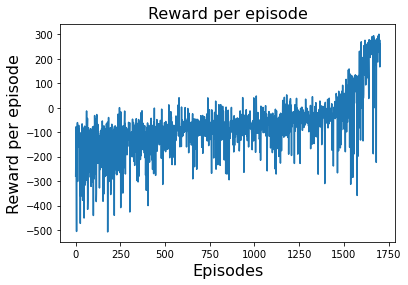

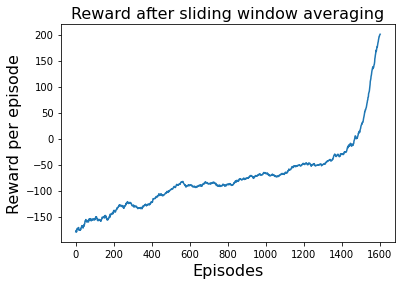

In [31]:
## PLOTS ##

def slidingaverage (data, window):
    weight = np.repeat(1.0, window)/window
    value_avg = np.convolve(data, weight, 'valid')
    return value_avg

plt.figure(0)
plt.plot(reward)
plt.ylabel("Reward per episode",fontsize=16)
plt.xlabel("Episodes",fontsize=16)
plt.title('Reward per episode', fontsize = 16)

reward_avg = slidingaverage(reward,100)
plt.figure(1)
plt.plot(reward_avg)   
plt.ylabel("Reward per episode",fontsize=16)
plt.xlabel("Episodes",fontsize=16)
plt.title('Reward after sliding window averaging', fontsize = 16)            
